In [95]:
import numpy as np

# Laplacian Matrix

#### Adjacency matrix

In [96]:
A = np.array([[0, 1, 1, 0, 0],
[1, 0, 1, 0, 0],
[1, 1, 0, 0, 0],
[0, 0, 0, 0, 1],
[0, 0, 0, 1, 0]])

#### Degree matrix

In [97]:
D = np.array([
[2, 0, 0, 0, 0],
[0, 2, 0, 0, 0],
[0, 0, 2, 0, 0],
[0, 0, 0, 1, 0],
[0, 0, 0, 0, 1]
])

In [98]:
L = D - A
L

array([[ 2, -1, -1,  0,  0],
       [-1,  2, -1,  0,  0],
       [-1, -1,  2,  0,  0],
       [ 0,  0,  0,  1, -1],
       [ 0,  0,  0, -1,  1]])

In [99]:
U, V = np.linalg.eig(L)

In [100]:
print(U)
print(V)

[ 3.00000000e+00 -3.77809194e-16  3.00000000e+00  2.00000000e+00
  0.00000000e+00]
[[ 0.81649658 -0.57735027  0.30959441  0.          0.        ]
 [-0.40824829 -0.57735027 -0.80910101  0.          0.        ]
 [-0.40824829 -0.57735027  0.49950661  0.          0.        ]
 [ 0.          0.          0.          0.70710678  0.70710678]
 [ 0.          0.          0.         -0.70710678  0.70710678]]


# Q2 image compression

In [2]:

import imageio
from matplotlib.pyplot import axis
import numpy as np
from scipy.spatial.distance import cdist
import time
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as img


class Kmean: 

    def __init__(self, img, distance='euclidean'):
        self.img = img
        self.distance = distance
        self.data = self.parse_image(img)


    def parse_image(self, img):
        """
        img: path to image

        return: 2D array of pixels in size (n x m, 3)
        """
        img = imageio.imread(img)
        
        # remove RGB-A format
        if img.shape[2] == 4:
            img = img[:, :, :3]
        
        self.H = img.shape[0]
        self.W = img.shape[1]
        
        return (img/255).reshape(-1, 3)




    def kmeans(self, X, k):
        
        """
        X: the reshaped image, each row is a pixel
        
        k: the number of clusters
        """
        
        self.k = k
        t0 = time.time()
        # Random centroid assignment
        rand_centroid = np.random.choice(len(X), k, replace=False)
        centroids = X[rand_centroid, :]
        
        # If the centroids were not unique from the random assignment,
        # continue to assign until the unique rows == k
        while np.unique(centroids, axis=0).shape[0] != k:
            rand_centroid = np.random.choice(len(X), k, replace=False)
            centroids = X[rand_centroid, :]
        
        tmpdiff = cdist(X, centroids, self.distance)

        labels = np.array([np.argmin(i) for i in tmpdiff])
        
        # Test if the new centroids differ from the previous ones by more than 1e-3
        convergence = False
        iteration = 0
        
        while convergence == False:
            
            
            iteration += 1
            centroids_prev = centroids
            tmp = []
            
            for cluster in range(k):
                
                # Use the mean for euclidian distance
                # or the median for the manhattan distance
                if self.distance == 'euclidean':
                    center = X[labels==cluster].mean(axis=0)
                else:
                    center = np.median(X[labels==cluster], axis=0)
                tmp.append(center)

            centroids = np.vstack(tmp)

            diff = cdist(X, centroids, self.distance)

            labels = np.array([np.argmin(i) for i in diff])

            if abs(centroids - centroids_prev).max() < 0.001:
                convergence = True
            
            t1 = time.time()
            
        
        
        self.labels = labels
        self.centroids = centroids
        self.iteration = iteration
        self.time_conv = round(t1 - t0, 3)
        
        print(f'Iteration to converge for {k} clusters is {iteration} in {(self.time_conv)} secs')


    def compress_img(self, trial=""):
        """
        k: the number of clusters for filename
        
        trial: additional information to add to file name 
        """
        x = [self.centroids[i] for i in self.labels]
        
        data = np.vstack(x).reshape(self.H, self.W, 3)
        
        plt.imshow(data)
        
        plt.imsave(f'{self.img}_{self.k}_cluster_{self.distance}_{self.iteration}_iter_{trial}.png', data)
        
    def attributes(self):
        
        df = pd.DataFrame(self.data)
        df['label'] = self.labels
        label_var = df.groupby('label')[df.drop('label', axis=1).columns].var().sum().sum()

        return {
            'image': self.img,
            'k': self.k,
            'distance': self.distance,
            'centroids': self.centroids * 255,
            'variance': label_var,
            'iteration': self.iteration,
            'time': self.time_conv
        }




In [9]:
def main(path, distance='euclidean'):
    iterations = [2, 4, 6, 8, 16]
    kmean = Kmean(path, distance)
    runs = []
    for i in iterations:
        for trial in range(5):
            kmean.kmeans(kmean.data, i)
            runs.append(kmean.attributes())
            kmean.compress_img(i)
    print()
    print(pd.DataFrame(runs).groupby('k')[['variance', 'iteration', 'time']].agg({'mean', 'var'}))

Iteration to converge for 2 clusters is 18 in 3.313 secs
Iteration to converge for 2 clusters is 8 in 1.57 secs
Iteration to converge for 2 clusters is 7 in 1.378 secs
Iteration to converge for 2 clusters is 10 in 1.887 secs
Iteration to converge for 2 clusters is 15 in 2.752 secs
Iteration to converge for 4 clusters is 15 in 2.77 secs
Iteration to converge for 4 clusters is 21 in 3.803 secs
Iteration to converge for 4 clusters is 21 in 3.838 secs
Iteration to converge for 4 clusters is 12 in 2.268 secs
Iteration to converge for 4 clusters is 13 in 2.453 secs
Iteration to converge for 6 clusters is 24 in 4.48 secs
Iteration to converge for 6 clusters is 11 in 2.141 secs
Iteration to converge for 6 clusters is 20 in 3.71 secs
Iteration to converge for 6 clusters is 19 in 3.502 secs
Iteration to converge for 6 clusters is 16 in 2.979 secs
Iteration to converge for 8 clusters is 52 in 9.398 secs
Iteration to converge for 8 clusters is 33 in 6.039 secs
Iteration to converge for 8 clusters 

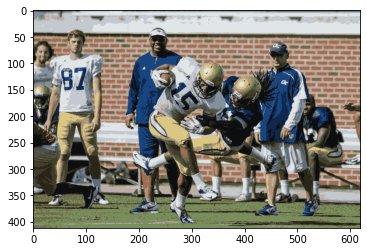

In [6]:
main('data/football.bmp')

Iteration to converge for 2 clusters is 6 in 0.756 secs
Iteration to converge for 2 clusters is 6 in 0.751 secs
Iteration to converge for 2 clusters is 6 in 0.755 secs
Iteration to converge for 2 clusters is 7 in 0.869 secs
Iteration to converge for 2 clusters is 8 in 0.978 secs
Iteration to converge for 4 clusters is 10 in 1.192 secs
Iteration to converge for 4 clusters is 15 in 1.736 secs
Iteration to converge for 4 clusters is 40 in 4.424 secs
Iteration to converge for 4 clusters is 21 in 2.403 secs
Iteration to converge for 4 clusters is 26 in 2.963 secs
Iteration to converge for 6 clusters is 27 in 3.102 secs
Iteration to converge for 6 clusters is 30 in 3.447 secs
Iteration to converge for 6 clusters is 16 in 1.907 secs
Iteration to converge for 6 clusters is 13 in 1.541 secs
Iteration to converge for 6 clusters is 35 in 3.977 secs
Iteration to converge for 8 clusters is 38 in 4.393 secs
Iteration to converge for 8 clusters is 59 in 6.746 secs
Iteration to converge for 8 clusters

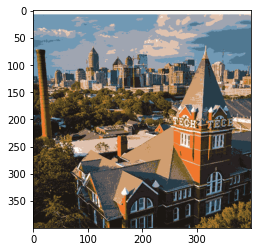

In [7]:
main('data/GeorgiaTech.bmp')

Iteration to converge for 2 clusters is 11 in 0.651 secs
Iteration to converge for 2 clusters is 11 in 0.635 secs
Iteration to converge for 2 clusters is 13 in 0.716 secs
Iteration to converge for 2 clusters is 12 in 0.66 secs
Iteration to converge for 2 clusters is 12 in 0.668 secs
Iteration to converge for 4 clusters is 13 in 0.732 secs
Iteration to converge for 4 clusters is 13 in 0.737 secs
Iteration to converge for 4 clusters is 24 in 1.299 secs
Iteration to converge for 4 clusters is 10 in 0.575 secs
Iteration to converge for 4 clusters is 15 in 0.84 secs
Iteration to converge for 6 clusters is 21 in 1.165 secs
Iteration to converge for 6 clusters is 50 in 2.682 secs
Iteration to converge for 6 clusters is 21 in 1.169 secs
Iteration to converge for 6 clusters is 48 in 2.582 secs
Iteration to converge for 6 clusters is 42 in 2.319 secs
Iteration to converge for 8 clusters is 65 in 3.659 secs
Iteration to converge for 8 clusters is 43 in 2.402 secs
Iteration to converge for 8 clust

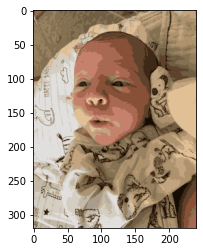

In [10]:
main('data/IMG_1401.png')

Iteration to converge for 2 clusters is 7 in 0.417 secs
Iteration to converge for 2 clusters is 7 in 0.413 secs
Iteration to converge for 2 clusters is 7 in 0.414 secs
Iteration to converge for 2 clusters is 9 in 0.518 secs
Iteration to converge for 2 clusters is 8 in 0.457 secs
Iteration to converge for 4 clusters is 12 in 0.683 secs
Iteration to converge for 4 clusters is 13 in 0.732 secs
Iteration to converge for 4 clusters is 11 in 0.627 secs
Iteration to converge for 4 clusters is 13 in 0.723 secs
Iteration to converge for 4 clusters is 25 in 1.355 secs
Iteration to converge for 6 clusters is 36 in 2.061 secs
Iteration to converge for 6 clusters is 16 in 0.96 secs
Iteration to converge for 6 clusters is 10 in 0.59 secs
Iteration to converge for 6 clusters is 20 in 1.136 secs
Iteration to converge for 6 clusters is 21 in 1.175 secs
Iteration to converge for 8 clusters is 34 in 1.909 secs
Iteration to converge for 8 clusters is 18 in 1.093 secs
Iteration to converge for 8 clusters i

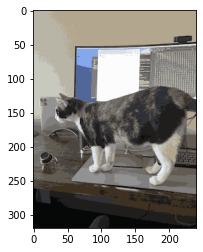

In [11]:
main('data/cat.png')

Iteration to converge for 2 clusters is 12 in 2.282 secs
Iteration to converge for 2 clusters is 9 in 1.744 secs
Iteration to converge for 2 clusters is 17 in 3.163 secs
Iteration to converge for 2 clusters is 6 in 1.231 secs
Iteration to converge for 2 clusters is 17 in 3.167 secs
Iteration to converge for 4 clusters is 20 in 3.75 secs
Iteration to converge for 4 clusters is 14 in 2.691 secs
Iteration to converge for 4 clusters is 13 in 2.518 secs
Iteration to converge for 4 clusters is 9 in 1.788 secs
Iteration to converge for 4 clusters is 12 in 2.319 secs
Iteration to converge for 6 clusters is 9 in 1.838 secs
Iteration to converge for 6 clusters is 11 in 2.18 secs
Iteration to converge for 6 clusters is 24 in 4.617 secs
Iteration to converge for 6 clusters is 44 in 8.185 secs
Iteration to converge for 6 clusters is 27 in 5.056 secs
Iteration to converge for 8 clusters is 24 in 4.61 secs
Iteration to converge for 8 clusters is 10 in 2.026 secs
Iteration to converge for 8 clusters i

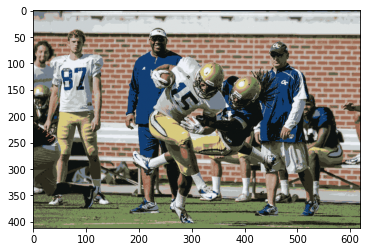

In [12]:
main('data/football.bmp', distance='cityblock')

Iteration to converge for 2 clusters is 6 in 0.767 secs
Iteration to converge for 2 clusters is 6 in 0.785 secs
Iteration to converge for 2 clusters is 7 in 0.878 secs
Iteration to converge for 2 clusters is 6 in 0.767 secs
Iteration to converge for 2 clusters is 6 in 0.77 secs
Iteration to converge for 4 clusters is 12 in 1.458 secs
Iteration to converge for 4 clusters is 7 in 0.911 secs
Iteration to converge for 4 clusters is 22 in 2.691 secs
Iteration to converge for 4 clusters is 14 in 1.709 secs
Iteration to converge for 4 clusters is 13 in 1.603 secs
Iteration to converge for 6 clusters is 18 in 2.214 secs
Iteration to converge for 6 clusters is 32 in 3.796 secs
Iteration to converge for 6 clusters is 33 in 3.854 secs
Iteration to converge for 6 clusters is 36 in 4.283 secs
Iteration to converge for 6 clusters is 38 in 4.511 secs
Iteration to converge for 8 clusters is 43 in 5.031 secs
Iteration to converge for 8 clusters is 37 in 4.413 secs
Iteration to converge for 8 clusters i

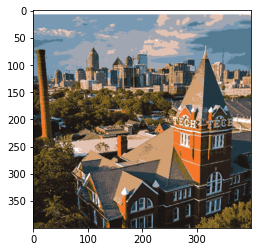

In [13]:
main('data/GeorgiaTech.bmp', distance='cityblock')

Iteration to converge for 2 clusters is 7 in 0.424 secs
Iteration to converge for 2 clusters is 8 in 0.476 secs
Iteration to converge for 2 clusters is 6 in 0.368 secs
Iteration to converge for 2 clusters is 7 in 0.418 secs
Iteration to converge for 2 clusters is 6 in 0.37 secs
Iteration to converge for 4 clusters is 11 in 0.653 secs
Iteration to converge for 4 clusters is 6 in 0.375 secs
Iteration to converge for 4 clusters is 8 in 0.48 secs
Iteration to converge for 4 clusters is 26 in 1.462 secs
Iteration to converge for 4 clusters is 18 in 1.024 secs
Iteration to converge for 6 clusters is 10 in 0.613 secs
Iteration to converge for 6 clusters is 15 in 0.876 secs
Iteration to converge for 6 clusters is 8 in 0.495 secs
Iteration to converge for 6 clusters is 17 in 1.007 secs
Iteration to converge for 6 clusters is 10 in 0.604 secs
Iteration to converge for 8 clusters is 48 in 2.705 secs
Iteration to converge for 8 clusters is 23 in 1.321 secs
Iteration to converge for 8 clusters is 9

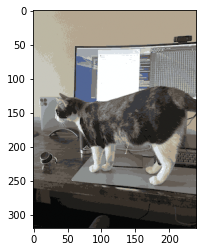

In [14]:
main('data/cat.png', distance='cityblock')

Iteration to converge for 2 clusters is 15 in 0.868 secs
Iteration to converge for 2 clusters is 13 in 0.745 secs
Iteration to converge for 2 clusters is 15 in 0.84 secs
Iteration to converge for 2 clusters is 9 in 0.526 secs
Iteration to converge for 2 clusters is 19 in 1.059 secs
Iteration to converge for 4 clusters is 21 in 1.187 secs
Iteration to converge for 4 clusters is 11 in 0.644 secs
Iteration to converge for 4 clusters is 13 in 0.753 secs
Iteration to converge for 4 clusters is 11 in 0.645 secs
Iteration to converge for 4 clusters is 11 in 0.65 secs
Iteration to converge for 6 clusters is 18 in 1.041 secs
Iteration to converge for 6 clusters is 45 in 2.532 secs
Iteration to converge for 6 clusters is 30 in 1.701 secs
Iteration to converge for 6 clusters is 17 in 0.99 secs
Iteration to converge for 6 clusters is 18 in 1.06 secs
Iteration to converge for 8 clusters is 12 in 0.727 secs
Iteration to converge for 8 clusters is 30 in 1.744 secs
Iteration to converge for 8 clusters

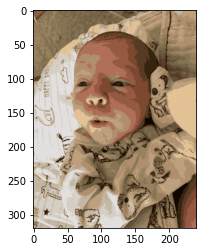

In [15]:
main('data/IMG_1401.png', distance='cityblock')